1. Tecnica de Aprendizaje Automatizado: Para la tecnica de aprendizaje automatico se utilizo el modelo ElasticNet, este es mucho mas util que el modelo lineal, porque evita sobreajuestes, cuando hay variables de poca influencia o mucho ruido.

2. El mercado y los activos: En este caso, para tener varios activos en los cuales invertir, y adicionalmente que sean lo suficiente mente variados los unos de otros, se utiliza el mercado S&P500, y se utilizan todos los activos.
Tal como se muestra en la siguiente linea de codigo

In [ ]:
stock_data = qndata.stocks.load_spx_data()

3. Variables: En este caso se agrego la variable momentum, la cual es útil para capturar la tasa de cambio del precio de un activo en un periodo de tiempo determinado en este caso en especifico es por el periodo de los últimos 10 días



4. En la parte de los objetivos, para poder comprar, mantenerce o vender, se realizo tal como se puede ver en el siguiente codigo

In [ ]:
def get_target_classes(data, threshold=0.01):

    price_current = data.sel(field="close")
    price_future = qnta.shift(price_current, -1)

    # Calculate percentage change
    price_change = (price_future - price_current) / price_current

    # Define target classes based on the change
    target_price_up = xr.where(price_change > threshold, 1, 0)  # 1: Significant upward movement
    target_price_down = xr.where(price_change < -threshold, -1, 0)  # -1: Significant downward movement

    # Combine the upward and downward targets
    target_classes = target_price_up + target_price_down

    return target_classes

5. Activos liquidos: Para los activos liquidos, simplemente se modifico el codigo que el profesor puso de ejemplo, tal como se puede ver en el siguiente codigo

In [ ]:
open = stock_data.sel(field='open')
close = stock_data.sel(field='close')
high = stock_data.sel(field='high')
low = stock_data.sel(field='low')

is_liquid = stock_data.sel(field='is_liquid')
stock_data = stock_data*is_liquid

Grafica 1 Comprando y vendiendo

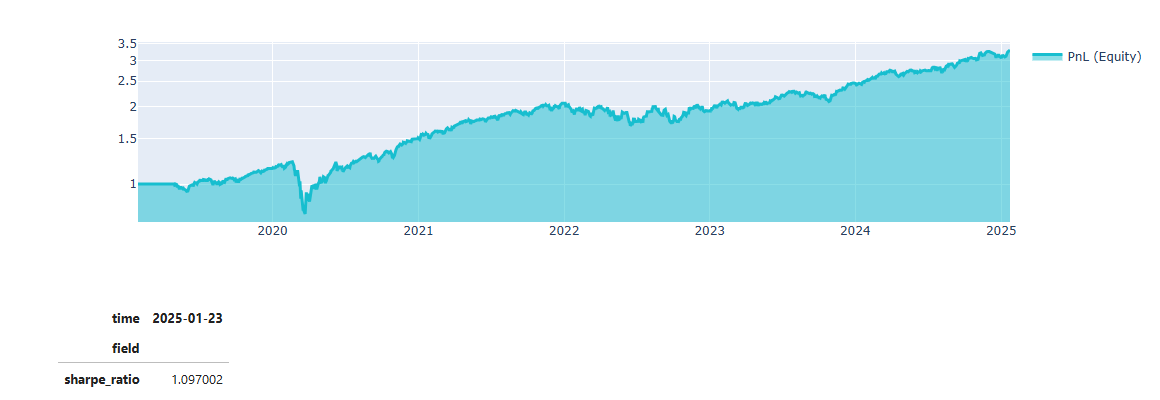


Grafica 2, comprando y vendiendo con el backtest

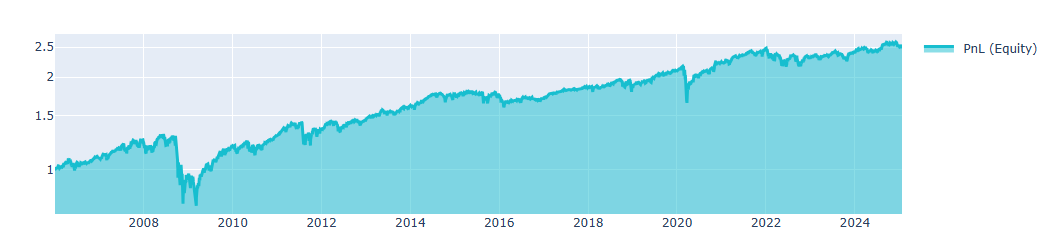

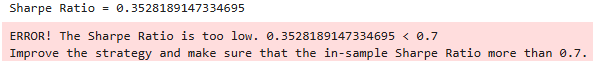

Grafica 3, Solo vendiendo
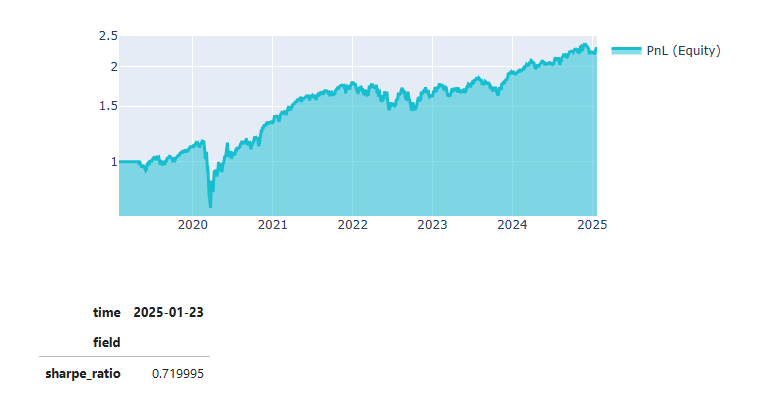



Grafica 4, Solo vendiendo con el backtest
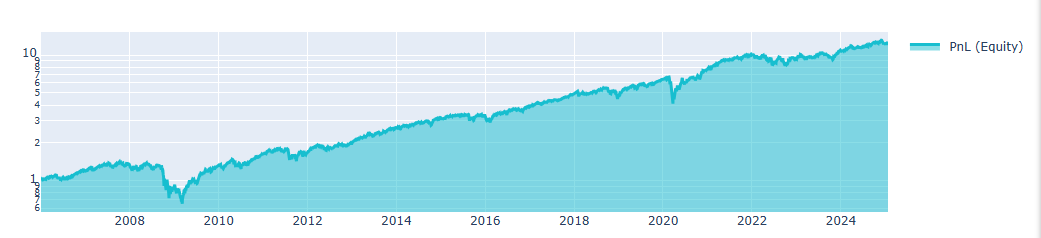

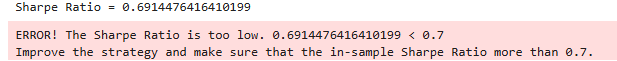


Grafica 5, Solo comprando
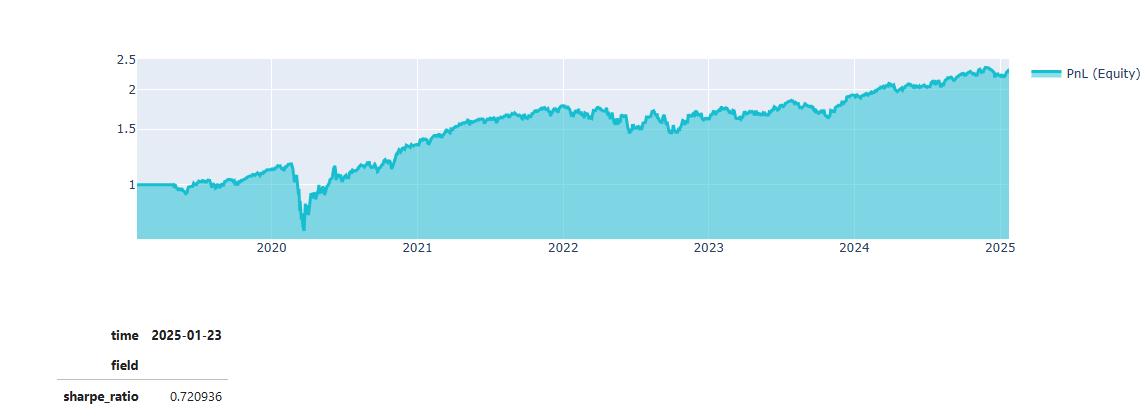

Grafica 6, Solo comprando con el backtest
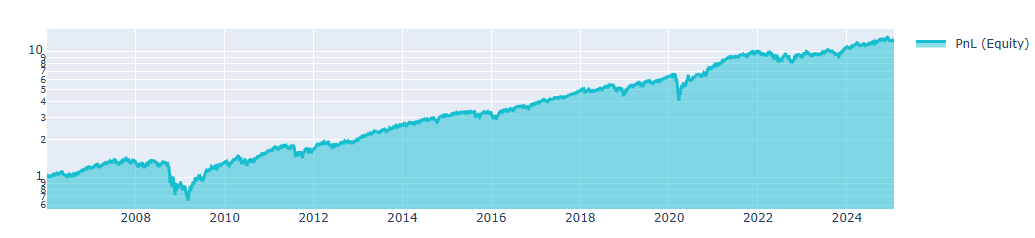

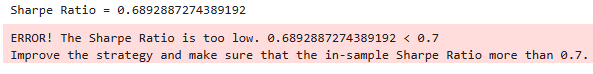

Codigo completo de la estrategia

In [ ]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# loading nasdaq-100 stock data

# stock_data = qndata.stocks.load_ndx_data((tail = 365 * 5), assets = ["NAS:AAPL", "NAS:AMZN"])


"""stock_data = qndata.stocks.load_spx_data(tail=365 * 5, assets = [
    "NAS:AAPL",   # Apple Inc. (Tecnología)
    "NAS:MSFT",   # Microsoft Corp. (Tecnología)
    "NAS:AMZN",   # Amazon.com Inc. (Consumo Discrecional)
    "NAS:GOOGL",  # Alphabet Inc. Clase A (Tecnología)
    "NAS:BRK.B",  # Berkshire Hathaway Inc. Clase B (Finanzas)
    "NAS:TSLA",   # Tesla Inc. (Consumo Discrecional)
    "NAS:JPM",    # JPMorgan Chase & Co. (Finanzas)
    "NAS:JNJ",    # Johnson & Johnson (Salud)
    "NAS:V",      # Visa Inc. Clase A (Finanzas)
    "NAS:PG",     # Procter & Gamble Co. (Consumo Básico)
    "NAS:NVDA",   # NVIDIA Corp. (Tecnología)
    "NAS:HD",     # Home Depot Inc. (Consumo Discrecional)
    "NAS:MA",     # Mastercard Inc. Clase A (Finanzas)
    "NAS:UNH",    # UnitedHealth Group Inc. (Salud)
    "NAS:DIS",    # Walt Disney Co. (Comunicación)
    "NAS:PYPL",   # PayPal Holdings Inc. (Tecnología Financiera)
    "NAS:XOM",    # Exxon Mobil Corp. (Energía)
    "NAS:KO",     # Coca-Cola Co. (Consumo Básico)
    "NAS:PFE",    # Pfizer Inc. (Salud)
    "NAS:CSCO"    # Cisco Systems Inc. (Tecnología)
])"""
# Estas me parecen que son las mejores opciones que brinda el fondo
# Por este motivo las elegi
stock_data = qndata.stocks.load_spx_data()


In [ ]:
open = stock_data.sel(field='open')
close = stock_data.sel(field='close')
high = stock_data.sel(field='high')
low = stock_data.sel(field='low')

is_liquid = stock_data.sel(field='is_liquid')
stock_data = stock_data*is_liquid


In [ ]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    
    trend1 = trend.shift(time=1)
    trend2 = trend.shift(time=2)
    trend3 = trend.shift(time=3)
    
    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    volatility1 = trend.shift(time=1)
    volatility2 = trend.shift(time=2)
    volatility3 = trend.shift(time=3)

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    d1 = trend.shift(time=1)
    d2 = trend.shift(time=2)
    d3 = trend.shift(time=3)
    
    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))

    rsi1 = trend.shift(time=1)
    rsi2 = trend.shift(time=2)
    rsi3 = trend.shift(time=3)

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)

    price1 = price.shift(time=1)
    price2 = price.shift(time=2)
    price3 = price.shift(time=3)
    # La variable momentum miide la tasa de cambio del precio en un periodo de tiempo,
    # por lo cual me parece que es útil para identificar la fuerza de una tendencia.
    momentum = qnta.roc(data.sel(field="close"), 10)  # Cambio porcentual en los últimos 10 días

    # combine the six features:
    result = xr.concat(
        [trend,trend1,trend2,trend3,
         macd2_signal.sel(field="close"),
         volatility,volatility1,volatility2,volatility3,
         d,d1,d2,d3,
         rsi,rsi1,rsi2,rsi3,
         price,price1,price2,price3,
         momentum],
        pd.Index(
            ["trend","trend1","trend2","trend3",
             "macd",
             "volatility","volatility1","volatility2","volatility3",
             "stochastic_d","stochastic_d1","stochastic_d2","stochastic_d3",
             "rsi","rsi1","rsi2","rsi3",
             "price","price1","price2","price3",
             "momentum"],
            name = "field"
        )
    )
    # En este codigo las dos variables agreadas son Momentum y adx
    # Momentum mide la tasa de cambio de los precios y ayuda a identificar tendencias fuertes.
    # ADX mide la fuerza de una tendencia, independientemente de su dirección.

    return result.transpose("time", "field", "asset")

In [ ]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

In [ ]:
# comprar y vender
def get_target_classes(data, threshold=0.01):
    
    price_current = data.sel(field="close")
    price_future = qnta.shift(price_current, -1)

    # Calculate percentage change
    price_change = (price_future - price_current) / price_current

    # Define target classes based on the change
    target_price_up = xr.where(price_change > threshold, 1, 0)  # 1: Significant upward movement
    target_price_down = xr.where(price_change < -threshold, -1, 0)  # -1: Significant downward movement

    # Combine the upward and downward targets
    target_classes = target_price_up + target_price_down

    return target_classes


In [ ]:
# solo vender
def get_target_classes(data, threshold=0.01):
    """ Target classes for predicting if price goes down (sell condition)."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_negative = 0 # price goes down (sell)
    class_positive = 1 # price goes up (buy) (you could disregard this if it's irrelevant)

    target_price_down = xr.where(price_future < price_current, class_negative, class_positive)

    return target_price_down


In [ ]:
# solo comprar
def get_target_classes(data, threshold=0.01):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down


    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

In [ ]:
from sklearn.linear_model import ElasticNet

def get_model():
    """This is a constructor for the ElasticNet model."""
    model = ElasticNet(alpha=1.0, l1_ratio=0.5)
    return model

In [ ]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model
        except:
            logging.exception("model training failed")


print(models)

In [ ]:
# Showing which features are more important in predicting:

importance = models["NAS:TSLA"].coef_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

In [ ]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

In [ ]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

In [ ]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

In [ ]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [ ]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_s&p500",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2006-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)